### This phase of the development notebook is mostly to figure out the TBC code, and refine the video RF decoding code.

In [1]:
# Just your usual setup

import numpy as np
import scipy as sp
import scipy.signal as sps
import scipy.fftpack as fftpack 
import matplotlib.pyplot as plt
import sys
import getopt

%matplotlib inline

import matplotlib
matplotlib.rc('figure', figsize=(20, 12))

from datetime import  datetime

import fft8 as fft8 
import ld_utils as utils

import copy

# for image display
from PIL import Image
from IPython.display import HTML
import IPython.display 
from io import BytesIO
from base64 import b64encode

In [2]:
pi = np.pi
tau = np.pi * 2

# Optimal if this is a power of 2
blocklenk = 2048
blocklen = (blocklenk * 1024)

In [3]:
# charting/graphing code carried over from earlier development efforts

def dosplot(B, A, freq = (315.0/88.0) * 8.0):
    w, h = sps.freqz(B, A)

    fig = plt.figure()
    plt.title('Digital filter frequency response')

    ax1 = fig.add_subplot(111)

    db = 20 * np.log10(abs(h))

    for i in range(1, len(w)):
        if (db[i] >= -10) and (db[i - 1] < -10):
            print(">-10db crossing at ", w[i] * (freq/pi) / 2.0) 
        if (db[i] >= -3) and (db[i - 1] < -3):
            print("-3db crossing at ", w[i] * (freq/pi) / 2.0) 
        if (db[i] < -3) and (db[i - 1] >= -3):
            print("<-3db crossing at ", w[i] * (freq/pi) / 2.0) 
        if (db[i] < -10) and (db[i - 1] >= -10):
            print("<-10db crossing at ", w[i] * (freq/pi) / 2.0) 
        if (db[i] < -20) and (db[i - 1] >= -20):
            print("<-20db crossing at ", w[i] * (freq/pi) / 2.0) 

    plt.plot(w * (freq/pi) / 2.0, 20 * np.log10(abs(h)), 'b')
    plt.ylabel('Amplitude [dB]', color='b')
    plt.xlabel('Frequency [rad/sample]')

    plt.show()

def doplot(B, A, freq = (315.0/88.0) * 8.0):
    w, h = sps.freqz(B, A)

    fig = plt.figure()
    plt.title('Digital filter frequency response')

    db = 20 * np.log10(abs(h))
    for i in range(1, len(w)):
        if (db[i] >= -10) and (db[i - 1] < -10):
            print(">-10db crossing at ", w[i] * (freq/pi) / 2.0) 
        if (db[i] >= -3) and (db[i - 1] < -3):
            print(">-3db crossing at ", w[i] * (freq/pi) / 2.0) 
        if (db[i] < -3) and (db[i - 1] >= -3):
            print("<-3db crossing at ", w[i] * (freq/pi) / 2.0) 

    ax1 = fig.add_subplot(111)

    plt.plot(w * (freq/pi) / 2.0, 20 * np.log10(abs(h)), 'b')
    plt.ylabel('Amplitude [dB]', color='b')
    plt.xlabel('Frequency [rad/sample]')

    ax2 = ax1.twinx()
    angles = np.unwrap(np.angle(h))
    plt.plot(w * (freq/pi) / 2.0, angles, 'g')
    plt.ylabel('Angle (radians)', color='g')

    plt.grid()
    plt.axis('tight')
    plt.show()

# plot two filters (haven't tested in a long while!)
def doplot2(B, A, B2, A2, freq = (315.0/88.0) * 8.0):
    w, h = sps.freqz(B, A)
    w2, h2 = sps.freqz(B2, A2)

    begin = 0
    end = len(w)
    chop = 0

    w = w[begin:end]
    w2 = w2[begin:end]
    h = h[begin:end]
    h2 = h2[begin:end]

    v = np.empty(len(w))

    hm = np.absolute(h)
    hm2 = np.absolute(h2)

    v0 = hm[0] / hm2[0]
    for i in range(0, len(w)):
        v[i] = (hm[i] / hm2[i]) / v0

    fig = plt.figure()
    plt.title('Digital filter frequency response')

    ax1 = fig.add_subplot(111)

    v  = 20 * np.log10(v )

    plt.plot(w * (freq/pi) / 2.0, 20 * np.log10(abs(h)), 'r')
    plt.plot(w * (freq/pi) / 2.0, 20 * np.log10(abs(h2)), 'b')
    plt.ylabel('Amplitude [dB]', color='b')
    plt.xlabel('Frequency [rad/sample]')

    ax2 = ax1.twinx()
    angles = np.unwrap(np.angle(h))
    angles2 = np.unwrap(np.angle(h2))
    plt.plot(w * (freq/pi) / 2.0, angles, 'g')
    plt.plot(w * (freq/pi) / 2.0, angles2, 'y')
    plt.ylabel('Angle (radians)', color='g')

    plt.grid()
    plt.axis('tight')
    plt.show()

# This matches FDLS-based conversion surprisingly well (i.e. FDLS is more accurate than I thought ;) )
def BA_to_FFT(B, A, blocklen):
    return np.complex64(sps.freqz(B, A, blocklen, whole=True)[1])

# Draws a uint16 image as a uint8, defaults to one frame
def drawdata(bm, x = 2800, y = 525, hscale = 1, vscale = 2, outsize = None):
#    bmf = np.float32(bm) / 65536.0
    if y is None:
        y = len(bm) // x
        
    if outsize is None:
        outsize = (x * hscale, y * vscale)
    
    bmf = np.uint8(bm[0:x*y] / 256.0)
    print(bmf.shape)
    if x is not None:
        bms = (bmf.reshape(len(bmf)//x, -1))
    else:
        bms = bmf
    
    print(bms.dtype, bms.shape, bms[:][0:y].shape)
    im = Image.fromarray(bms[0:y])
    im = im.resize(outsize)
    b = BytesIO()
    im.save(b, format='png')
    return IPython.display.Image(b.getvalue())


In [4]:
# System default specs for NTSC and PAL.

NTSC_hz_ire = (9300000 - 7600000) / 140.0 # Later disks may have a higher white point

SysParams_NTSC = {
    'system_name': 'NTSC',
    
    'audio_lfreq': 2301136,
    'audio_rfreq': 2812499,

    'analog_audio': True,

    'fsc_mhz': (315.0 / 88.0),
    'line_period': 63.5, # in usecs

    # video frequencies 
    # per spec, range from -40 to 100 IRE is 1.7mhz, so 12142 ire/mhz
    'hz_ire': NTSC_hz_ire,
    
    'videorf_sync'  : 8100000-(NTSC_hz_ire * -40),
    'videorf_0ire'  : 8100000,
    'videorf_7.5ire': 8100000+(NTSC_hz_ire*7.5),
    'videorf_100ire': 8100000+(NTSC_hz_ire*100), # NOTE: slightly higher on later disks

    # IRE range is actually -40 to 110, but leave some margin here and match 0-65534 scaling
    'ire_min': -60,
    'ire_max': 140,

    # tunable parameters.  These work well with DD 2_2 + eliptical filter, which is a bit more
    # picky about audio RF filtering.
    
    #'deemp': (120, 320), # actual deemp timing... at least the usec #'s.
    'deemp': (120*.7, 320*.7), # On some captures this is as low as .55.

    # The audio notch filters didn't work right until the ellipcital filter was implemented...
    'audio_filtwidth': 150000,
    'audio_filtorder': 1,

    # similar but not identical to what Pioneer did
    'vbpf': (3500000, 13200000),
    'vbpf_order': 3,
    
    # This can easily be pushed up to 4.5mhz...
    'vlpf_freq': 4200000,   # in mhz
    'vlpf_order': 5 # butterworth filter order
    
}

SysParams_PAL = {
    # System parameters
    'system_name': 'PAL',

    'fsc_mhz': 4.43361875,
    'line_period': 64, # in usecs
    
    'audio_lfreq': 683593,
    'audio_rfreq': 1066400,

    # video frequencies 
    'videorf_sync': 6760000, # on LD this includes a very strong pilot signal
    'videorf_0ire': 7100000,
    'videorf_100ire': 7900000,

    'ire_min': -95, # needed for pilot signal
    'ire_max': 145,

    # changeable defaults
    'analog_audio': False, # not true for later PAL

    'deemp': (100, 400),

    # XXX: guessing here!
    'vbpf': (2600000, 11000000),
    'vbpf_order': 3,
    'vlpf_freq': 4800000,	# in mhz
    'vlpf_order': 5,		# butterworth filter order

    'audio_filtwidth': 200000,
    'audio_filtorder': 1,
}

# support reloading/rerunning from ipython
try:
    # a dummy load
    tmp = SysParams['fsc_mhz']
except:
    SysParams = copy.deepcopy(SysParams_NTSC)
    

In [5]:
# Domesday Duplicator system uses 32mhz/10bit, expressed as 16-bit signed integers
CapParams_DomesdayDuplicator = {
    'freq': 40.0,
    'dtype': np.int16,
}

# cxadc can only really capture at 8fsc (28.8xmhz), with 8-bit unsigned samples
# (I haven't used cxadc data in this dev cycle, so the parameters are probably wrong!)
CapParams_cxadc = {
    'freq': (315.0 / 88.0) * 8.00,
    'dtype': np.uint8,
}

In [6]:
CapParams = CapParams_DomesdayDuplicator
SysParams = copy.deepcopy(SysParams_NTSC)

In [7]:
OverrideParams = {}

params = {}

for p in [SysParams, CapParams, OverrideParams]:
    for k in p.keys():
        print(k, p[k])
        params[k] = p[k]

system_name NTSC
audio_lfreq 2301136
audio_rfreq 2812499
analog_audio True
fsc_mhz 3.5795454545454546
line_period 63.5
hz_ire 12142.857142857143
videorf_sync 8585714.285714285
videorf_0ire 8100000
videorf_7.5ire 8191071.428571428
videorf_100ire 9314285.714285715
ire_min -60
ire_max 140
deemp (84.0, 224.0)
audio_filtwidth 150000
audio_filtorder 1
vbpf (3500000, 13200000)
vbpf_order 3
vlpf_freq 4200000
vlpf_order 5
freq 40.0
dtype <class 'numpy.int16'>


In [8]:
def inrange(a, mi, ma):
    return (a >= mi) & (a <= ma)

def sqsum(cmplx):
    return np.sqrt((cmplx.real ** 2) + (cmplx.imag ** 2))

This generation of ld-decode uses FFT multiplication to perform convolutions. This allows multiple filter types to be "stacked" into a minimal number of general operations.

In [9]:
# from http://tlfabian.blogspot.com/2013/01/implementing-hilbert-90-degree-shift.html
hilbert_filter = np.fft.fftshift(
    np.fft.ifft([0]+[1]*200+[0]*200)
)

# Now construct the FFT transform of the hilbert filter.  
# This can be complex multiplied with the raw RF to do the 'heavy lifting'
fft_hilbert = np.fft.fft(hilbert_filter, blocklen)

def filtfft(filt, blen = blocklen):
    return sps.freqz(filt[0], filt[1], blen, whole=1)[1]

In [10]:
# A rather pants attempt at doing an MTF function, but it seems to work well...
[tf_b, tf_a] = sps.zpk2tf(.1, -.5, 1.0)
Fmtf = filtfft([tf_b, tf_a])

# This prepares the needed transforms to do the actual video decoding
def prepare_video_filters(params):
    SP = copy.deepcopy(params)
    
    SP['freq_hz'] = SP['freq'] * 1000000.0
    SP['line_px'] = SP['freq_hz'] * (SP['line_period'] / 1000000.0)
        
    freq_hz = SP['freq_hz']
    freq_hz_half = SP['freq_hz'] / 2

    # RF BPF and analog audio cut filters
    SP['FRFVideo'] = filtfft(sps.butter(SP['vbpf_order'], [SP['vbpf'][0]/freq_hz_half, SP['vbpf'][1]/freq_hz_half], btype='bandpass'))
    
    if SP['analog_audio'] and SP['audio_filtorder']: 
        SP['Fcutl'] = filtfft(sps.butter(SP['audio_filtorder'], [(SP['audio_lfreq'] - SP['audio_filtwidth'])/freq_hz_half, (SP['audio_lfreq'] + SP['audio_filtwidth'])/(freq_hz_half)], btype='bandstop'))
        SP['Fcutr'] = filtfft(sps.butter(SP['audio_filtorder'], [(SP['audio_rfreq'] - SP['audio_filtwidth'])/freq_hz_half, (SP['audio_rfreq'] + SP['audio_filtwidth'])/(freq_hz_half)], btype='bandstop'))
        
        SP['FRFVideo'] *= (SP['Fcutl'] * SP['Fcutr'])
    
    # standard post-demod LPF
    SP['Fvideo_lpf'] = filtfft(sps.butter(SP['vlpf_order'], SP['vlpf_freq']/freq_hz_half, 'low'))
    SP['Fvideo_lpf05'] = filtfft(sps.butter(SP['vlpf_order'], 0.5/freq_hz_half, 'low'))

    # post-demod deemphasis filter
    [tf_b, tf_a] = sps.zpk2tf(-SP['deemp'][1]*(10**-10)/2.0, -SP['deemp'][0]*(10**-10)/2.0, SP['deemp'][0] / SP['deemp'][1])
    SP['Fdeemp'] = filtfft(sps.bilinear(tf_b, tf_a, 1.0/freq_hz_half))

    # Post processing:  lowpass filter + deemp
    SP['FVideo'] = SP['Fvideo_lpf'] * SP['Fdeemp']
    SP['FVideo05'] = SP['Fvideo_lpf05'] * SP['Fdeemp']
    
    # emperical work determined that a single-pole low frequency filter effectively 
    # detects the end of a (regular) sync pulse. TODO: test with PAL
    f = sps.butter(1, 0.05/(params['freq'] / 2.0), btype='low')
    SP['FPsync'] = filtfft(f)
    
    return SP

In [11]:
# The actual video demodulation code

def dodemod(paramsc, data, clip = None, usemtf = False, cutarf = False):
    indata_fft = np.fft.fft(data1)
    indata_fft_filt = indata_fft * paramsc['FRFVideo']

    if usemtf:
        indata_fft_filt *= Fmtf

    hilbert = np.fft.ifft(indata_fft_filt * fft_hilbert)

    tangles = np.angle(hilbert)
    dangles = np.pad(np.diff(tangles), (1, 0), mode='constant')

    # make sure unwapping goes the right way
    if (dangles[0] < -pi):
        dangles[0] += tau

    tdangles2 = np.unwrap(dangles) 
    tdangles2[tdangles2 < 0] += tau
    tdangles2[tdangles2 > tau] -= tau
    demod = (tdangles2 * (paramsc['freq_hz'] / tau))

    demod_fft = np.fft.fft(demod)
    output = np.fft.ifft(demod_fft * paramsc['FVideo']).real

    return output

In [12]:
def lineplot(output, param):
    plt.plot(output)
    
    if param['system_name'] == 'PAL':
        plt.axhline(7100000, color='black') # black
        plt.axhline(7900000, color='black') # white

        # burst
        plt.axhline(7100000 - (800000 * 1.5 / 7), color='g')
        plt.axhline(7100000 + (800000 * 1.5 / 7), color='g')

        # pilot low (pilot high is 7.1mhz)
        plt.axhline((7900000-(800000/.7))-(800000*(3/7)), color='b')
    else: # NTSC
        
        plt.axhline(params['videorf_0ire'], color='black') # 0IRE
        plt.axhline(params['videorf_7.5ire'], color='black') # black for most disks
        plt.axhline(params['videorf_100ire'], color='black') # white

        plt.axhline(params['videorf_0ire'] + (params['hz_ire'] * 80), color='blue')
        
        plt.axhline(params['videorf_0ire'] + (params['hz_ire'] * 20), color='green')
        plt.axhline(params['videorf_0ire'] - (params['hz_ire'] * 20), color='green')
        
        # sync
        plt.axhline(params['videorf_0ire'] + (params['hz_ire'] * -40), color='blue')

In [13]:
def calcsnr(a):
    stdire = np.std(a) / NTSC_hz_ire
    return(20 * np.log10(100 / stdire))

In [14]:
# old lddecode format for hz->uint16 conversion
minire = -60
maxire = 140
hz_ire_scale = (9300000 - 8100000) / 100
minn = 8100000 + (hz_ire_scale * -60)
out_scale = 65534.0 / (maxire - minire)

In [15]:
# nice GGV sample (40msps)
#infile = open('ggv1069_22000.raw', 'rb')

# discovision logo (rotted :P )
#infile = infile = open('/home/cpage/erica_44a.raw', 'rb')
#infile.seek(1024 * 1024 * 1400)

infile = infile = open('/home/cpage/ve22_44zonea.raw', 'rb')

inbuf = infile.read(1024 * 1024 * 8)
indata1 = np.fromstring(inbuf, 'int16', len(inbuf) // 2)

data1 = indata1[400000:400000+blocklen]
#data2 = indata1[blocklen:blocklen*2]


In [66]:
blockcut = 1024

params['freq'] = 44.0
params['deemp'] = (120*.65, 320*.65)
filterset = prepare_video_filters(params)

output = dodemod(filterset, data1, usemtf=False)


In [67]:
output

array([ 7642062.05721499,  7618677.34244951,  7537730.23675251, ...,
        7625410.98542859,  7634611.84101405,  7641408.37079266])

Below this is the less developed code to deal with NTSC framing and syncs.

In [68]:
# NTSC: filtering for vsync pulses from -55 to -25ire seems to work well even on rotted disks

output_sync = (output > (params['videorf_0ire'] + (params['hz_ire'] * -55))) & (output < (params['videorf_0ire'] + (params['hz_ire'] * -25)))

# Perform FFT convolution of above filter
output_syncf = np.fft.ifft(np.fft.fft(output_sync) * filterset['FPsync']).real

A plot of output_syncf here shows a nice pattern overall:

- Vsyncs reach 1.0 (and the mininum in those areas is ~0.23)
- regular hsyncs come in about 0.77 (the glitches are where the LD player "rewinds" for still frames)
- equalization pulses come in about 0.5

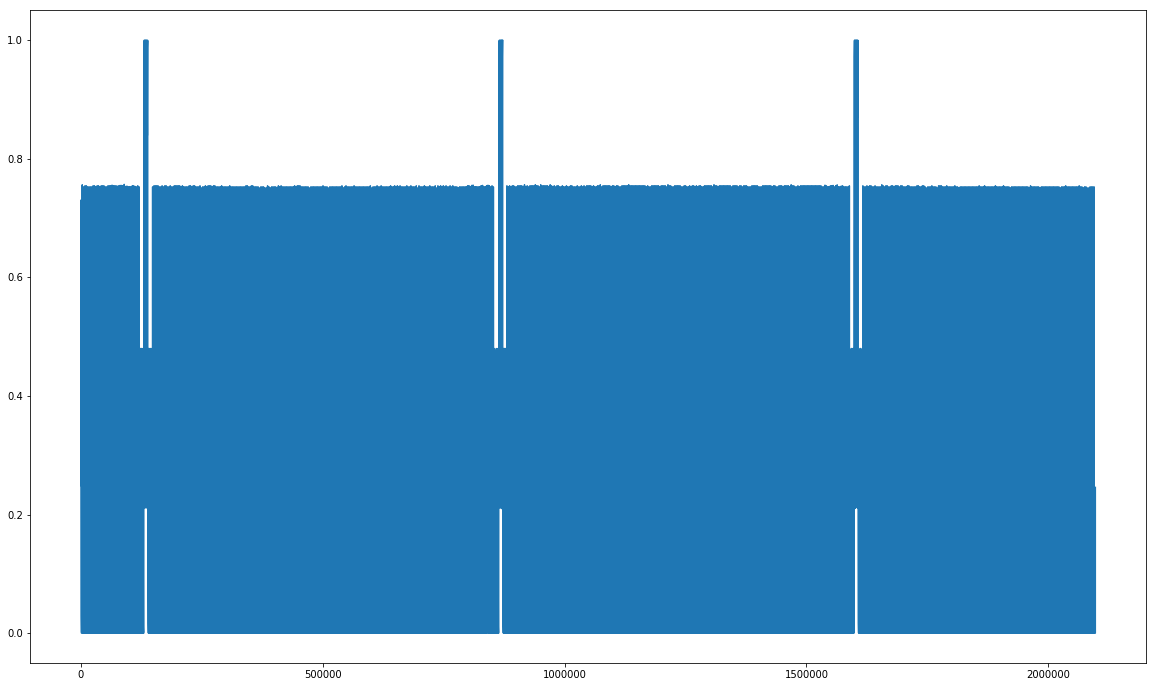

In [69]:
# This shows some nice patterns.  The glitches near the odd #'d syncs
plt.plot(output_syncf)

In [70]:
# state 1: find vsync and first full hsync.  determine which line it is as well...

loc = 400000
imglen = (int)((filterset['freq_hz'] / 59.976) * 1.25)

if (loc + imglen) > len(output_syncf):
    print("get more data")

# find the next sync point.  should be > .9
syncloc = np.argmax(output_syncf[loc:loc+imglen]) + loc

if np.max(output_syncf[loc:loc+imglen]) < .9:
    print("oops.  can't find a good sync")

syncloc

869178

In [71]:
def findburstfromsync(syncf, center):
    ilinepx = int(filterset['line_px'])

    if syncf[center] < .2:
        print('invalid location')
    try:
        scanarea = (ilinepx * 6)
        threshold = .15

        startsync = center - scanarea + np.where(syncf[center - scanarea:center] < threshold)[0][-1]
        # note: endsync usually includes the first equalization pulse
        endsync = center + np.where(syncf[center:center + scanarea] < threshold)[0][0]
    except:
        print('oh oh, sync ends not found')

    try:
        lastlinepresync = (startsync - (ilinepx * 4)) + np.where(syncf[startsync - (ilinepx * 4): startsync] > .55)[0][-1]
        # compute equalization length with .08 compensation factor
        presync_eqlen = ((startsync - lastlinepresync) / ilinepx) + .08
    except:
        print("error: couldn't find prev line")
        lastlinepresync = None
        presync_eqlen = None

    try:
        nextline = endsync + np.where(syncf[endsync: endsync + (ilinepx * 4)] > .55)[0][0]
        # the offset is larger here since the first equalization pulse is close enough to the end of vsync
        postsync_eqlen = ((nextline - endsync) / ilinepx) + .56
    except:
        print("error: couldn't find next line")
        nextline = None
        postsync_eqlen = None

    return (lastlinepresync, nextline, presync_eqlen, postsync_eqlen)

prevline, nextline, pregap, postgap = findburstfromsync(output_syncf, syncloc)

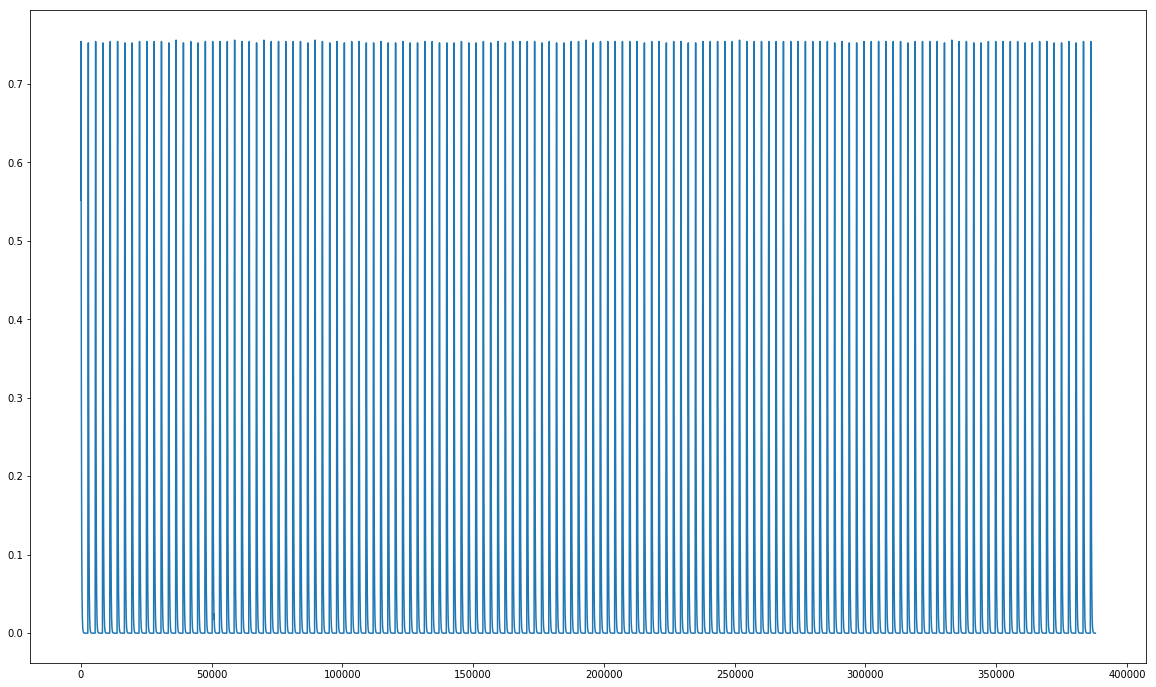

In [72]:
plt.plot(output_syncf[nextline:syncloc+399430])

In [73]:
reduced = (output - minn) / hz_ire_scale
output_u16 = np.uint16(np.clip(reduced * out_scale, 0, 65535) + 0.5)

In [74]:
# state 2: find the (rough) locations of each following line

ilinepx = int(filterset['line_px'])
lines = np.zeros((255 * ilinepx), dtype=np.uint16)

curloc = nextline

lineinfo = [curloc]
for i in range(0, 253):
    prevloc = curloc
    
    curloc += int(filterset['line_px'] * .9)
    offset = np.argmax(output_syncf[curloc:curloc + int(filterset['line_px'] * .2)])
    curloc += offset 
    
    # if the sync detection burst doesn't look good, reuse the last one
    is_validlinegap = inrange((curloc - prevloc), filterset['line_px'] * .997, filterset['line_px'] * 1.003)
    validaftersync = (np.max(output[curloc:curloc + 20]) < 8500000) and (np.min(output[curloc:curloc + 20]) >= 7600000)
    if ((output_syncf[curloc] < .7) and not is_validlinegap) or not validaftersync:
        print(i, curloc)
        curloc = prevloc + (lineinfo[-1] - lineinfo[-2])
        
    #print(curloc, output[curloc], output[curloc+8])

    lineinfo.append(curloc)
    
    lines[i * ilinepx:(i * ilinepx)+(curloc - prevloc)] = output_u16[prevloc:curloc]
    
#    if (i == 119):
#        break

In [75]:
m20ire = 8100000-hz_ire_scale*20

In [76]:
# crude zero-crossing calculator.

def calczc(data, start_offset, target, count=10):
    if data[start_offset] < target:
        locs = np.where(data[start_offset:start_offset+count] >= target)[0]
        offset = 0
    else:
        locs = np.where(data[start_offset:start_offset+count] <= target)[0]
        offset = -1
    
    if len(locs) == 0:
        return None
        
    x = start_offset + locs[0]
    
    a = data[x - 1] - target
    b = data[x] - target
    
    y = -a / (-a + b)

    #print(x, y, locs, data[start_offset:start_offset+locs[0] + 1])

    return x-1+y


In [77]:
video_05 = filtfft(sps.butter(3, 0.5/22, 'low'))
output_lp = np.fft.ifft(np.fft.fft(output) * video_05).real[29:] 

In [79]:
lineinfo2 = []

for l in lineinfo:
    zc = calczc(output_lp, l - 5, m20ire, 20)
    
    if zc is None:
        lineinfo2.append(l)
        continue
        
    lineinfo2.append(zc)
    print(l, output[l], output[l + 1], output[l + 2])
    


883575 7733325.5139 7804925.07445 7888912.1704
886372 7776700.60836 7854482.10417 7934454.89281
889168 7744010.5815 7812881.24809 7888836.59685
891965 7756714.84211 7823586.48682 7901422.06483
894762 7778140.94237 7852692.10066 7936182.37315
897558 7749872.53569 7812034.14594 7884071.19546
900355 7762178.26118 7840566.61898 7923371.07508
903152 7787934.75017 7859955.4589 7936700.59112
905949 7792433.94087 7866159.57121 7945675.51467
908745 7752804.13146 7820351.90565 7892852.74847
911542 7768858.06119 7832310.45575 7904709.3186
914338 7741522.54034 7798349.72025 7856790.75585
917136 7775611.56483 7848717.79426 7931172.83898
919932 7743953.36575 7804141.95706 7867504.96772
922730 7777623.45991 7854180.74427 7938185.1539
925526 7737806.75037 7799168.91539 7866478.62314
928324 7788217.65674 7866044.83311 7947714.96832
931120 7746393.96742 7796497.83523 7857062.74202
933918 7784189.97606 7853582.52515 7930265.94458
936715 7794214.35097 7869382.77391 7944708.3615
939512 7773522.31722 783595

In [80]:
lineinfo2e = []

c = 0
for l in lineinfo:
    zc = calczc(output_lp, int(l - 10 + (filterset['line_px'] * 55 / 63.5)), m20ire, 200)
    
    if zc is None:
        lineinfo2e.append(l)
        continue
        
    lineinfo2e.append(zc)
    print(l, lineinfo2[c], lineinfo2e[c], output[l], output[l + 1], output[l + 2])
    c += 1
    


883575 880695 880695 7733325.5139 7804925.07445 7888912.1704
886372 883576.581828 886175.258269 7776700.60836 7854482.10417 7934454.89281
889168 886373.102562 888971.979995 7744010.5815 7812881.24809 7888836.59685
891965 889169.406367 891768.457128 7756714.84211 7823586.48682 7901422.06483
894762 891965.921417 894564.861788 7778140.94237 7852692.10066 7936182.37315
897558 894762.643568 897361.86809 7749872.53569 7812034.14594 7884071.19546
900355 897559.140277 900158.373481 7762178.26118 7840566.61898 7923371.07508
903152 900355.998499 902955.095769 7787934.75017 7859955.4589 7936700.59112
905949 903152.974226 905751.661737 7792433.94087 7866159.57121 7945675.51467
908745 905949.455896 908548.477648 7752804.13146 7820351.90565 7892852.74847
911542 908746.627464 911346.507064 7768858.06119 7832310.45575 7904709.3186
914338 911543.275167 914142.957751 7741522.54034 7798349.72025 7856790.75585
917136 914340.014078 916939.289013 7775611.56483 7848717.79426 7931172.83898
919932 917136.85092

In [81]:
# experiment:  filter color burst data for easier alignment

In [82]:
video_cburst = filtfft(sps.butter(2, [(300/88.0)/22, (330/88.0)/22], 'bandpass'))


In [83]:
output_cburst = np.fft.ifft(np.fft.fft(output - 8100000) * video_cburst).real[98:] + 8100000

In [84]:
calczc(output_lp, int(lineinfo2[250])-80, m20ire, 200), calczc(output, int(lineinfo2[250])-80, m20ire, 200)

(1580252.4904514544, 1580252.4832291966)

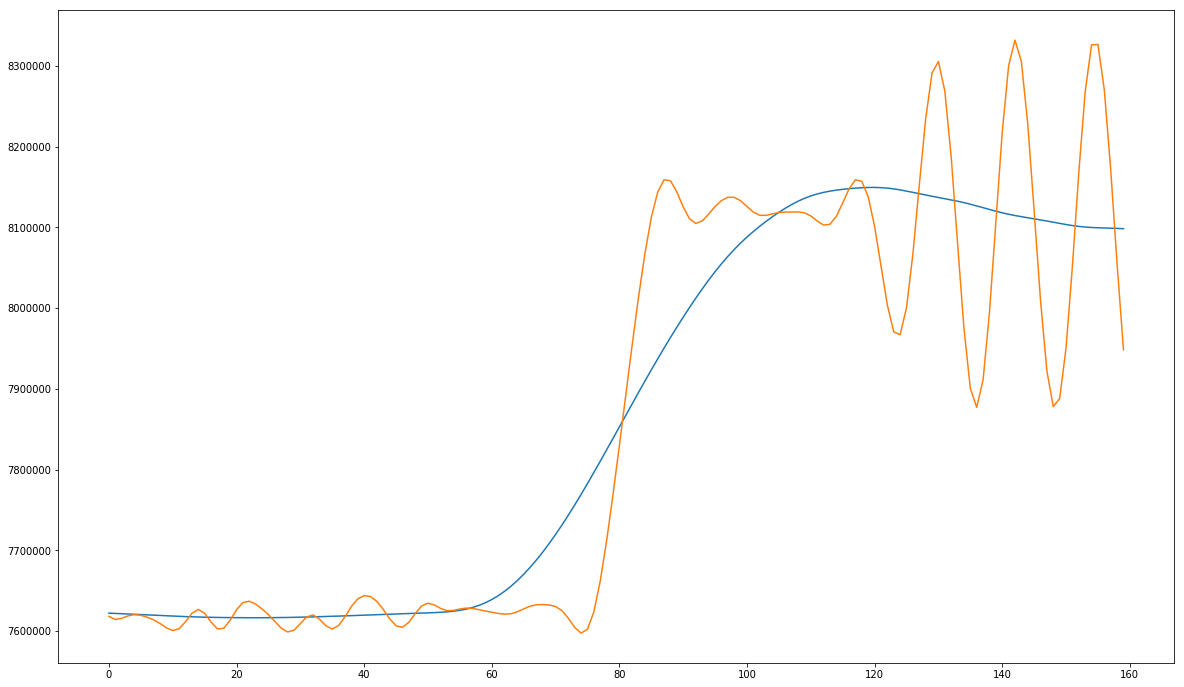

In [85]:
plt.plot(output_lp[int(lineinfo2[250]-80):int(lineinfo2[250])+80])
plt.plot(output[int(lineinfo2[250])-80:int(lineinfo2[250])+80])
#plt.plot(output[int(lineinfo2[50]):int(lineinfo2[51])])

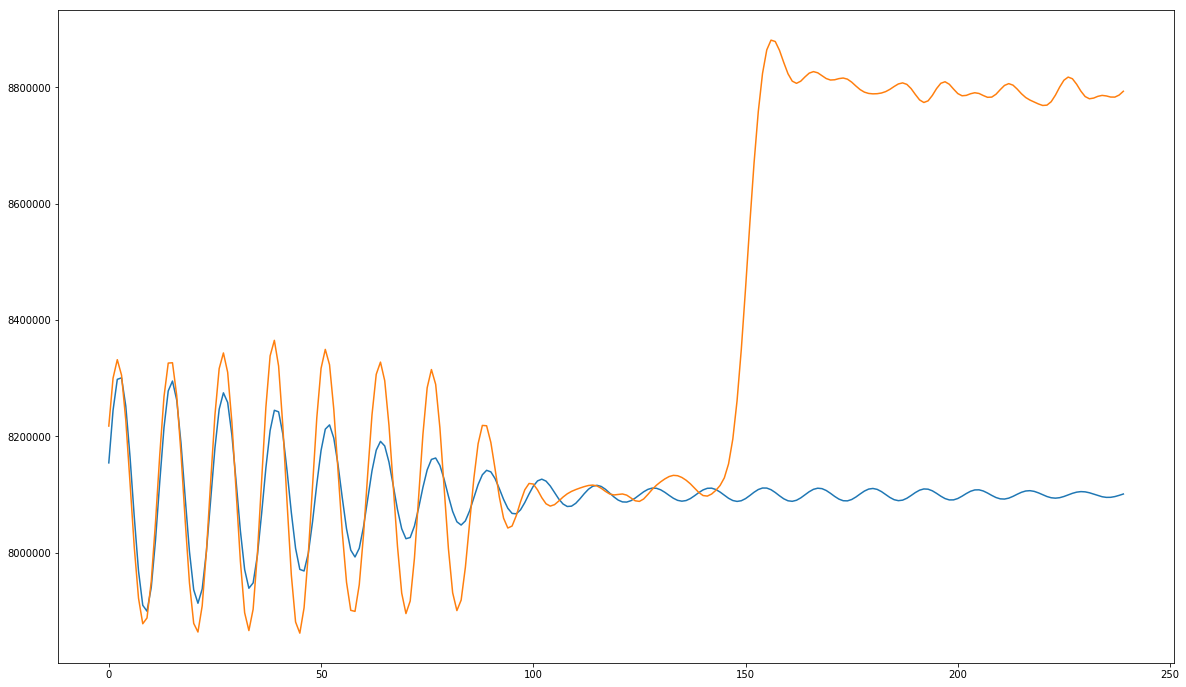

In [86]:
plt.plot(output_cburst[int(lineinfo2[250]+60):int(lineinfo2[250])+300])
plt.plot(output[int(lineinfo2[250])+60:int(lineinfo2[250])+300])
#plt.plot(output[int(lineinfo2[50]):int(lineinfo2[51])])

In [87]:
lineinfo2 = []

for l in lineinfo:
    zc = calczc(output_lp, l - 5, m20ire, 20)
    
    if zc is None:
        lineinfo2.append(l)
        continue
        
    lineinfo2.append(zc)
    print(l, output[l], output[l + 1], output[l + 2])
    


883575 7733325.5139 7804925.07445 7888912.1704
886372 7776700.60836 7854482.10417 7934454.89281
889168 7744010.5815 7812881.24809 7888836.59685
891965 7756714.84211 7823586.48682 7901422.06483
894762 7778140.94237 7852692.10066 7936182.37315
897558 7749872.53569 7812034.14594 7884071.19546
900355 7762178.26118 7840566.61898 7923371.07508
903152 7787934.75017 7859955.4589 7936700.59112
905949 7792433.94087 7866159.57121 7945675.51467
908745 7752804.13146 7820351.90565 7892852.74847
911542 7768858.06119 7832310.45575 7904709.3186
914338 7741522.54034 7798349.72025 7856790.75585
917136 7775611.56483 7848717.79426 7931172.83898
919932 7743953.36575 7804141.95706 7867504.96772
922730 7777623.45991 7854180.74427 7938185.1539
925526 7737806.75037 7799168.91539 7866478.62314
928324 7788217.65674 7866044.83311 7947714.96832
931120 7746393.96742 7796497.83523 7857062.74202
933918 7784189.97606 7853582.52515 7930265.94458
936715 7794214.35097 7869382.77391 7944708.3615
939512 7773522.31722 783595

In [88]:
# now to get fine sync!

In [89]:
from scipy import interpolate

# This uses numpy's interpolator, which works well enough
def scale(buf, begin, end, tgtlen):
#        print("scaling ", begin, end, tgtlen)
        ibegin = int(begin)
        iend = int(end)
        linelen = end - begin

        dist = iend - ibegin + 0
        
        sfactor = dist / tgtlen
        
        arr, step = np.linspace(0, dist, num=dist + 1, retstep=True)
        spl = interpolate.splrep(arr, buf[ibegin:ibegin + dist + 1])
        arrout = np.linspace(begin - ibegin, linelen + (begin - ibegin), tgtlen + 1)

        return interpolate.splev(arrout, spl)[:-1]
    

x = np.arange(0, 400)
scale(x, 50.5, 60.5, 10)

array([ 50.5,  51.5,  52.5,  53.5,  54.5,  55.5,  56.5,  57.5,  58.5,  59.5])

In [90]:
def downscale(data, lineinfo):
    dsout = np.zeros((len(lineinfo) * ilinepx), dtype=np.double)    

    sfactor = []

    for l in range(0, len(lineinfo) - 1):
#        scaled = scale(data, lineinfo[l] + 0, lineinfo[l + 1], 910)
#        sfactor.append((lineinfo[l + 1] - lineinfo[l]) / 910)
        scaled = scale(data, lineinfo[l][0], lineinfo[l][1], 910)
        sfactor.append((lineinfo[l][1] - lineinfo[l][0]) / 910)

        dsout[l * 910:(l + 1)*910] = scaled
        
    return dsout, sfactor

#lines, sfactor = downscale(output_cburst, lineinfo3)
    
#reduced = (lines - minn) / hz_ire_scale
#lines16 = np.uint16(np.clip(reduced * out_scale, 0, 65535) + 0.5)


In [91]:
#drawdata(lines16, 910, len(lineinfo2)-1, hscale=2, vscale=4)

In [92]:
def phasecorrect(sdata, lineinfo, mult = 0.25):
    loutput = []
    errors = []

    #loutput.append(lineinfo[0])
    for l in range(0, len(lineinfo) - 1):
        subset = sdata[l * 910: (l + 1) * 910][5:60]

        if (np.min(subset) < 7600000) or (np.max(subset) > 8500000):
            loutput.append(lineinfo[l])
            errors.append(0)
            continue
        
        peaks = np.where(np.abs(subset - 8100000) > 80000)[0]
        toffset = 0

        for loc in peaks:
            zp = calczc(subset, loc, 8100000)

            if zp is not None:
                offset = (zp - loc - 1)
                toffset += offset
            else:
                offset = 0

    #        print(zp, offset)

        errors.append(toffset)
        #print(l, toffset / len(peaks) * sfactor[l])

        if len(peaks):
            loutput.append(lineinfo[l] - ((toffset * mult) / len(peaks) * sfactor[l]))
        else:
            loutput.append(lineinfo[l])

    loutput.append(lineinfo[-1])
    
    return loutput, errors

In [93]:
def calcerr(line):
    subset = line[5:60]
    
    black = np.mean(subset)
    
    peaks = np.where(np.abs(subset - black) > 100000)[0]
    toffset = 0
    noffsets = 0

    for loc in peaks:
        zp = calczc(subset, loc, black)

        #print(loc, subset[loc], zp)
        
        if zp is not None:
            offset = (zp - loc - 1)
            toffset += offset
            noffsets += 1
        else:
            offset = 0
            
    try:
        return toffset / noffsets
    except:
        return 0


In [94]:
910 * 1.2

1092.0

In [121]:
lineinfo_tmp = lineinfo2.copy()
#lineinfo3 = [(lineinfo2[0], lineinfo[1])]
lineinfo3 = [(lineinfo2[0], lineinfo[1])]
finalsnr = []

# because of odd issues, it makes sense to do one line and the next burst together, and so on...
for l in range(1, len(lineinfo2) - 1):
    for i in range(0, 5):
        # compute 1.2x
        linelen = lineinfo_tmp[l + 1] - lineinfo_tmp[l]
        line12end = lineinfo_tmp[l] + (linelen * 1.2)

        scaled = scale(output_cburst, lineinfo_tmp[l], line12end, 1092) # 1092 is 1.2x 910
#        sfactor.append((lineinfo[l + 1] - lineinfo[l]) / 910)

        offset1 = calcerr(scaled[0:60])
        offset2 = calcerr(scaled[910:970])
        print(l, i, offset1, offset2, calcsnr((scaled[10:50] + scaled[920:960]) / 2))

#        lineinfo_tmp[l] -= (offset1 * (linelen / 910) * (.5 / (i + 1)))
        #lineinfo3[l + 1] += (offset1 * (linelen / 910) * .25)
        if (i == 0):
            lineinfo_tmp[l + 1] += ((offset2 - offset1) * (linelen / 910) * (0.83 / (i + 1)))
        else:
            lineinfo_tmp[l] += (offset1 * (linelen / 910) * (.2 / (i + 1)))
            lineinfo_tmp[l + 1] += ((offset2) * (linelen / 910) * (.2 / (i + 1)))
            
    lineinfo3.append((lineinfo_tmp[l], lineinfo_tmp[l + 1]))
    linelen = lineinfo3[l][1] - lineinfo3[l][0]
    line12end = lineinfo3[l][0] + (linelen * 1.2)

    scaled = scale(output, lineinfo3[l][0], line12end, 1092) # 1092 is 1.2x 910
    offset1 = calcerr(scaled[0:60])
    offset2 = calcerr(scaled[910:970])
    finalsnr.append(calcsnr((scaled[10:50] + scaled[920:960]) / 2))
    print(l, 'f', offset1, offset2, calcsnr((scaled[10:50] + scaled[920:960]) / 2))
    
lineinfo3.append((lineinfo2[-1], lineinfo2[-1] + linelen))
#lineinfo3.append(lineinfo2[-1])

1 0 0.106207295684 0.173340570733 45.8011378941
1 1 0.104295260916 0.104215046704 49.3283054093
1 2 0.0906022005972 0.0905465228768 49.32923152
1 3 0.0824996651979 0.0824576487942 49.329756689
1 4 0.0768906204494 0.0768576217121 49.3301113459
1 f -0.0659405406008 -0.066748721214 36.6054632124
2 0 0.0798014929015 0.257579512808 38.7864368392
2 1 0.0746773718506 0.0855007287022 55.2251434705
2 2 0.0642899576759 0.0738395238739 55.42677256
2 3 0.0582293006881 0.0670011820925 55.5414534045
2 4 0.0540699400065 0.062293637575 55.6185592598
2 f -0.0854196067132 -0.0973258402552 37.7571109733
3 0 0.0647488950144 0.32361600253 35.3823249529
3 1 0.057114493263 0.0898831820647 55.3228679508
3 2 0.0488084521906 0.0776504763232 56.4871881507
3 3 0.0439960575102 0.0704672111569 57.2293050152
3 4 0.0407114960172 0.0655183929584 57.7666556553
3 f -0.116793205754 -0.113376507431 39.6291175971
4 0 0.0697257900162 0.272641405816 37.6738741354
4 1 0.0637647885992 0.0809951561972 56.1411148676
4 2 0.054675

42 f -0.140427973692 -0.017428040675 35.3609563273
43 0 -0.0451252333289 0.143099034177 39.2136479759
43 1 -0.0508524765559 -0.0803222150517 47.5684381116
43 2 -0.0434707627112 -0.0694190464597 47.6759368595
43 3 -0.0392177560893 -0.0630460710314 47.7294714465
43 4 -0.0363250252646 -0.0586648025246 47.7620395947
43 f -0.00447552027896 -0.215544566056 39.1018787867
44 0 -0.0499016216311 0.121522401564 40.6195439908
44 1 -0.0550097395556 -0.0852879892904 45.6984585291
44 2 -0.0471481920265 -0.0738943294005 45.8570735803
44 3 -0.0426151202365 -0.0671932803842 45.9455323103
44 4 -0.0395247620392 -0.0625712099632 46.0041891256
44 f -0.201389170967 -0.133024930906 37.1475717305
45 0 -0.0548589063736 0.151631065178 38.2727867161
45 1 -0.061104109289 -0.0903828334264 44.8645610054
45 2 -0.052536412416 -0.0784261359383 44.9291926824
45 3 -0.0475570064041 -0.0713385044458 44.9623366354
45 4 -0.044147365353 -0.0664623950026 44.9829794226
45 f -0.168879233677 -0.144064458482 39.8211922319
46 0 -0.

81 4 -0.0404367479391 -0.0626630549411 46.3104893988
81 f -0.128898201499 -0.186349250731 39.2226676133
82 0 -0.055404225558 0.0647804713887 43.3419044872
82 1 -0.0589403619363 -0.0841005285981 46.8209129623
82 2 -0.0506171103531 -0.0728589930909 46.9528717507
82 3 -0.0457963708916 -0.0662500025356 47.025944457
82 4 -0.0425057668187 -0.0616924240697 47.0741832217
82 f -0.172170795794 -0.127610606914 41.070068326
83 0 -0.05545518606 0.110636458908 40.4924790412
83 1 -0.0603019886567 -0.0902310966643 48.3628555243
83 2 -0.0518342909789 -0.0782781402487 48.5141386792
83 3 -0.0469151536684 -0.0712335504076 48.5920288871
83 4 -0.0435200193549 -0.0663682928053 48.6405767766
83 f -0.162111456612 -0.0805569457579 39.5898614872
84 0 -0.0551833032073 0.151581368995 39.1803221947
84 1 -0.0612494769856 -0.0916124205008 47.249311063
84 2 -0.0526032748505 -0.0795178488484 47.4487392773
84 3 -0.0475652870577 -0.0723843621879 47.5599707278
84 4 -0.044114653819 -0.067455334521 47.633706796
84 f -0.0639

124 2 -0.0422629746489 -0.0655375022246 45.4205627864
124 3 -0.0382058514183 -0.0594873430691 45.480587845
124 4 -0.0354408119835 -0.0553264464974 45.5200108932
124 f -0.0868654709665 -0.1368699187 40.1149307809
125 0 -0.0469739160727 0.143362385529 39.7357180933
125 1 -0.0526164455568 -0.0827543093295 48.7382217429
125 2 -0.0450892746714 -0.0716361130586 48.9426895592
125 3 -0.0407349210604 -0.0651059595393 49.0524039196
125 4 -0.0377224610869 -0.0606055033813 49.1230373973
125 f -0.175510978779 -0.199652450464 37.9211408339
126 0 -0.0527328270661 0.112359748129 40.7915514621
126 1 -0.0575654460766 -0.0872236729726 45.4898629463
126 2 -0.0493764149639 -0.0755983557525 45.6323066939
126 3 -0.0446356525128 -0.0687564093508 45.711511232
126 4 -0.0413989513895 -0.064035201224 45.7639525156
126 f -0.184921443288 -0.194359524898 41.9076028315
127 0 -0.055478356964 0.122941683381 40.0991347761
127 1 -0.0607690162902 -0.0914327438931 48.501830421
127 2 -0.0521625270292 -0.0793779284132 48.676

162 0 -0.0528974140642 -0.0262140760574 48.2762766402
162 1 -0.0536913357931 -0.058862919505 48.5072726147
162 2 -0.0460946534564 -0.0506641177884 48.5231967665
162 3 -0.0417092037657 -0.0458770422833 48.5321767333
162 4 -0.0387170804833 -0.0425618881301 48.5381613912
162 f -0.0880287787663 -0.108518478757 37.0165106709
163 0 -0.0380725036533 0.0217915470828 44.1717336213
163 1 -0.0399280914215 -0.0518156402336 45.6983030753
163 2 -0.0340481165008 -0.0446232488997 45.7069942053
163 3 -0.0306760838788 -0.0404315486367 45.7109586649
163 4 -0.0283791941272 -0.0375705934684 45.7131871035
163 f -0.147330421087 -0.173290974543 36.9279887788
164 0 -0.0360229949232 -0.0120656561427 44.1965361348
164 1 -0.036742091205 -0.0423261429277 44.1111314613
164 2 -0.0315037378884 -0.0362266986168 44.1243246615
164 3 -0.0284933278021 -0.0327037984601 44.1316649339
164 4 -0.0264462942745 -0.0302939027086 44.1365441398
164 f -0.165630786411 -0.0718064575357 36.5618716269
165 0 -0.0269808951091 0.0186828198

202 3 -0.0416429334461 -0.061087611791 48.6721077839
202 4 -0.0386056622871 -0.0568348537361 48.7368148067
202 f -0.189291214564 -0.183088673859 39.1796359418
203 0 -0.0491053306599 0.115942703885 40.6169336762
203 1 -0.0539782213062 -0.0836283254258 47.7896575689
203 2 -0.0462850629815 -0.0724235618846 47.9204992993
203 3 -0.0418003349134 -0.0658389504878 47.9880271711
203 4 -0.0387137507095 -0.0612993349416 48.0303222568
203 f -0.170124282506 -0.223977132234 39.1562778636
204 0 -0.0518453447542 0.104594472037 40.6482656231
204 1 -0.0564361504879 -0.0854546943617 44.7452639819
204 2 -0.048401944308 -0.0740180062271 44.8435200932
204 3 -0.0437573258987 -0.0672931037214 44.8969252961
204 4 -0.0405748664024 -0.062655262532 44.931738347
204 f -0.209084320245 -0.174490066253 38.1706690738
205 0 -0.0541164526427 0.184930923402 37.191028373
205 1 -0.061335654933 -0.0900896665821 45.2942620583
205 2 -0.052719509658 -0.0781786250262 45.3846329165
205 3 -0.0477130031054 -0.0711570527347 45.4327

246 1 0.00658711876551 0.00277075981389 46.3852095997
246 2 0.00558348956815 0.00235570857 46.3921739539
246 3 0.00501650597551 0.00212041594033 46.395984297
246 4 0.00463451341105 0.0019615556657 46.3985009397
246 f -0.137546859826 -0.106772080912 34.522306493
247 0 0.00819893582104 0.250860990498 36.3326080227
247 1 0.00201024373484 0.00110587106018 45.7996487172
247 2 0.00170215743808 0.000939582903667 45.7986195974
247 3 0.00152823562101 0.000845383377182 45.7980344578
247 4 0.00141111865717 0.000781812239381 45.797638786
247 f -0.107099331401 -0.148404635 44.0645190352
248 0 0.00801673216499 0.201670397489 38.5341153911
248 1 0.00179505958873 -0.0142035471046 44.2352449813
248 2 0.00158143432751 -0.0119700136367 44.2621084738
248 3 0.00145457978968 -0.0107139831143 44.2760472503
248 4 0.00136650461518 -0.00986956829904 44.2849279792
248 f -0.147648124643 -0.151484541945 40.9427955976
249 0 -0.00223669482575 0.248620684769 36.3153375747
249 1 -0.0103495446843 -0.0138210334136 49.07

In [122]:
np.mean(finalsnr), np.min(finalsnr), np.argmin(finalsnr)

(38.510729274197786, 32.977262212264385, 147)

In [118]:
for i in range(len(lineinfo3) - 1):
    print(i, lineinfo3[i + 1][0] - lineinfo3[i][1], lineinfo3[i])

0 1.48946352582 (880695, 883575)
1 -0.125992504647 (883576.48946352582, 886373.18151372729)
2 -0.177540348144 (886373.05552122265, 889169.54999957979)
3 -0.250841634697 (889169.37245923164, 891966.01325005689)
4 -0.129325340851 (891965.76240842219, 894762.33253485209)
5 -0.103650675854 (894762.20320951124, 897558.90169791749)
6 -0.241284447373 (897558.79804724164, 900355.94607126329)
7 -0.17221799551 (900355.70478681591, 903152.56257959199)
8 -0.0778918334981 (903152.39036159648, 905949.09531701787)
9 -0.165224954719 (905949.01742518437, 908746.59866895026)
10 -0.210330468835 (908746.43344399554, 911543.05475575302)
11 -0.221095727175 (911542.84442528419, 914339.81303211628)
12 -0.148110739421 (914339.5919363891, 917136.44044557284)
13 -0.201102721156 (917136.29233483342, 919933.44875492551)
14 -0.133829099243 (919933.24765220436, 922730.21494602051)
15 -0.23262807331 (922730.08111692127, 925527.47739214986)
16 -0.105616208864 (925527.24476407655, 928324.13088702061)
17 -0.216077078017

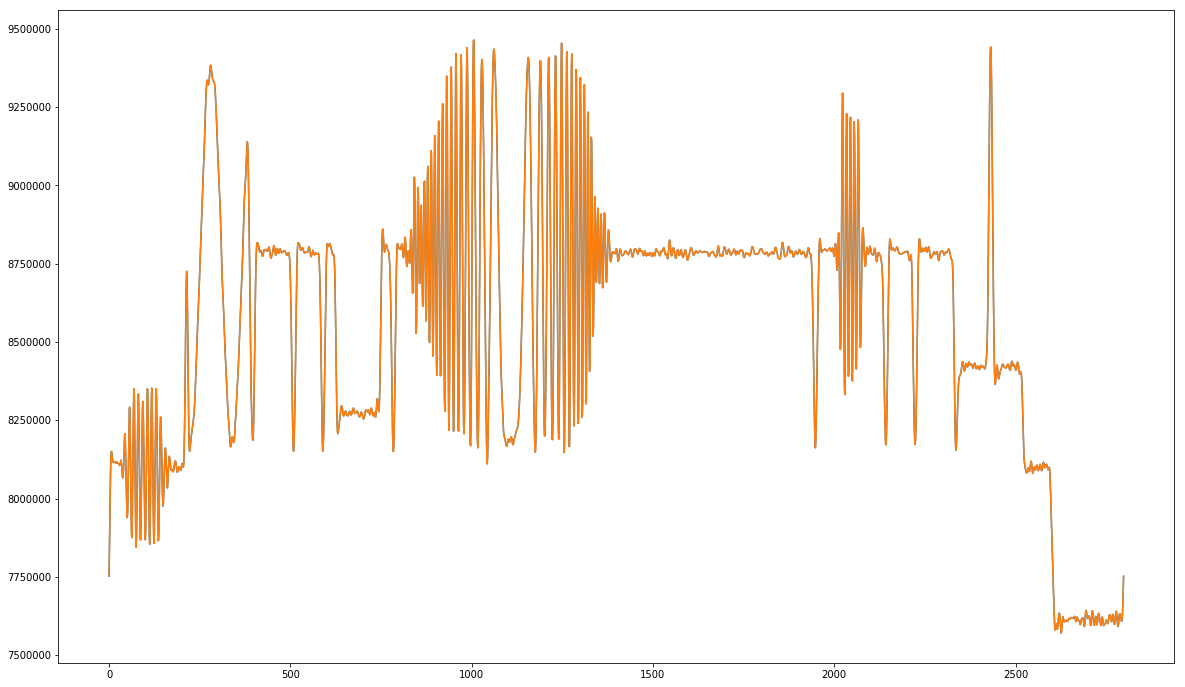

In [119]:
plt.plot(output[1303258:1306057])
plt.plot(output[1303258:1306057])

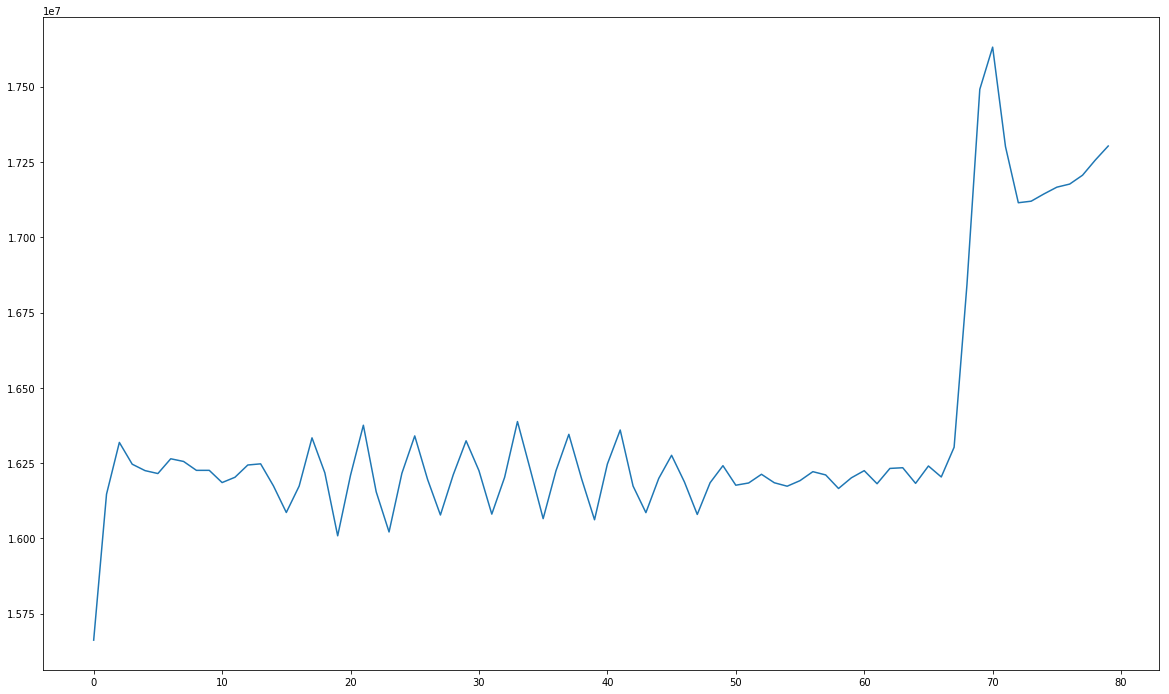

In [120]:
l1 = 153
#plt.plot(lines[(l1 * 910):(l1 * 910) + 80])
l2 = 154
#plt.plot(lines[(l2 * 910):(l2 * 910) + 80])
plt.plot(lines[(l1 * 910):(l1 * 910) + 80] + lines[(l2 * 910):(l2 * 910) + 80])

35.0758032138
(230230,)
uint8 (253, 910) (253, 910)


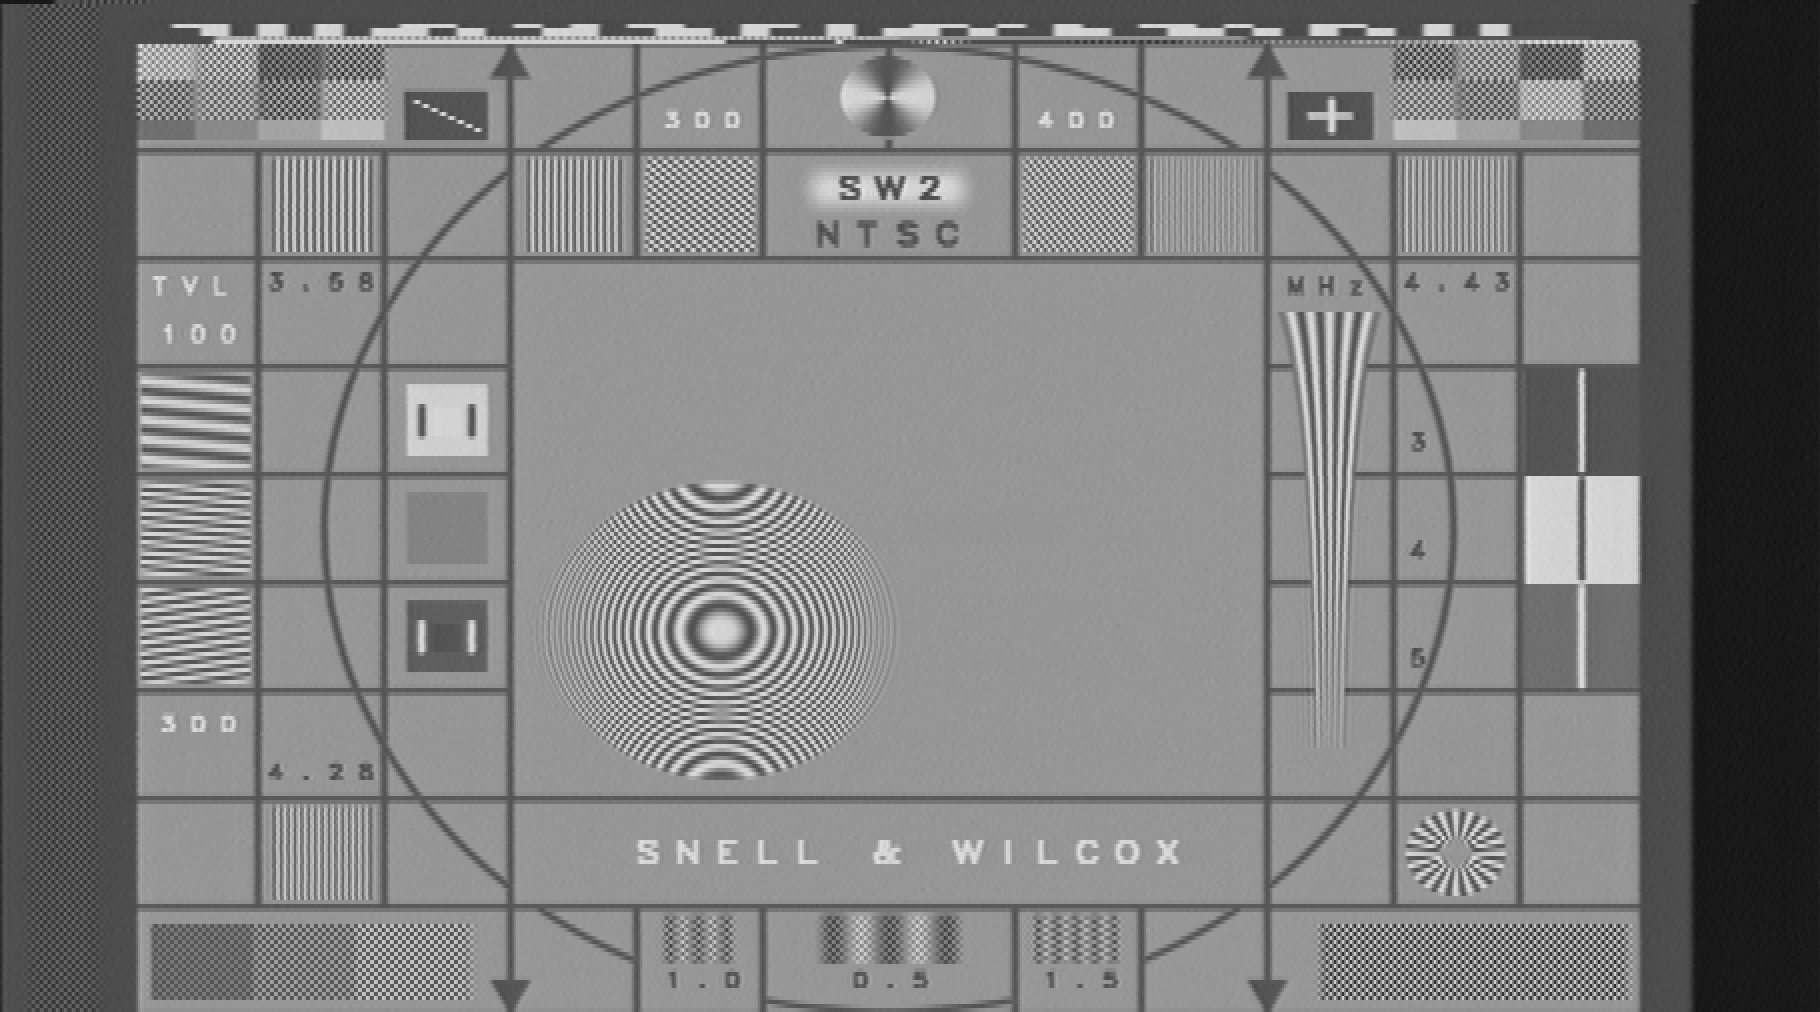

In [110]:
print(np.mean(finalsnr))
lines, sfactor = downscale(output, lineinfo3)

reduced = (lines - minn) / hz_ire_scale
lines16 = np.uint16(np.clip(reduced * out_scale, 0, 65535) + 0.5)

drawdata(lines16, 910, len(lineinfo2)-1, hscale=2, vscale=4)

(230230,)
uint8 (253, 910) (253, 910)


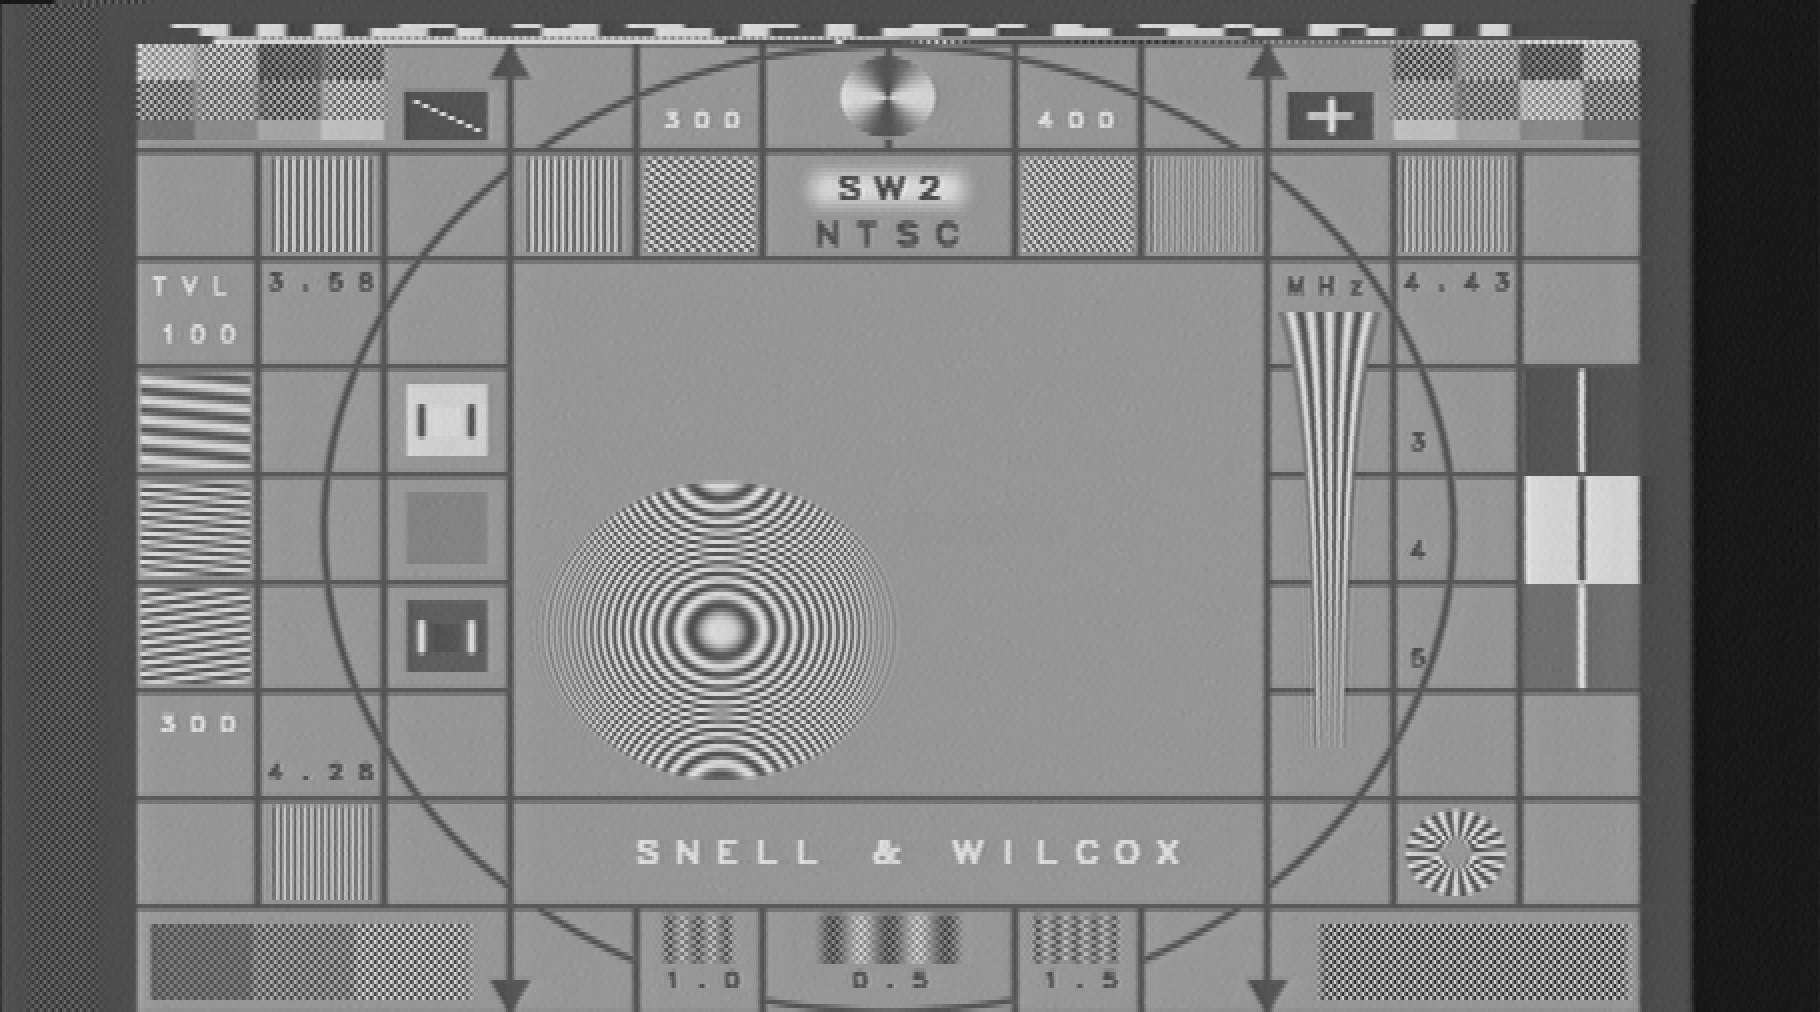

In [694]:
def downscale2(data, lineinfo):
    dsout = np.zeros((len(lineinfo) * ilinepx), dtype=np.double)    

    for l in range(0, len(lineinfo) - 1):
        scaled = scale(data, lineinfo[l][0], lineinfo[l + 1][1], 910)
        dsout[l * 910:(l + 1)*910] = scaled
        
    return dsout

lines, downscale2(output_cburst, lineinfo3)
    
reduced = (lines - minn) / hz_ire_scale
lines16 = np.uint16(np.clip(reduced * out_scale, 0, 65535) + 0.5)
drawdata(lines16, 910, len(lineinfo3)-1, hscale=2, vscale=4)

In [695]:
snr = []
zcstart = []
zcend = []
zclen = []
for l in range(2, 250):
    preline = lines[(l * 910) - 20: (l * 910) + 20]
    _line = lines[(l * 910):(l + 2) * 910]
    
    x = lines[(910*l)+0:(910*l)+80]
    y = (x + lines[(910*l)+910:(910*l)+990]) / 2
    #plt.plot(y)

    zcstart.append(calczc(preline, 0, m20ire, 40) - 20)
    zcend.append(calczc(_line, 830, m20ire, 40))
    nextstart = calczc(_line, 900, m20ire, 40)
    zclen.append(nextstart - zcend[-1])
    snr.append(calcsnr(y[15:50]))
    print(l, calczc(preline, 0, m20ire, 40) - 20, calczc(_line, 830, m20ire, 40), calczc(_line, 900, m20ire, 40), calcsnr(y[15:50]))

2 -0.154741137918 845.368979898 909.861959977 37.4950262196
3 -0.138040022963 845.484546213 909.9074071 39.53515591
4 -0.0925929003539 845.450885029 909.909596074 38.2483850861
5 -0.0904039259235 845.431623837 909.909069945 38.7810154812
6 -0.090930054506 845.442284106 909.86090586 38.7791257511
7 -0.139094139965 845.425737295 909.832417702 39.7752201802
8 -0.167582298308 845.27221555 909.925389741 38.3505643762
9 -0.0746102585259 845.027630874 909.812592829 34.1564994399
10 -0.187407171451 845.224789305 909.883270826 38.0456201704
11 -0.116729174283 845.393663928 909.831584864 37.2948848883
12 -0.168415135823 845.195340354 909.928115571 36.7303025515
13 -0.0718844287775 845.338972519 909.837234703 36.2558223715
14 -0.162765296637 845.386983961 909.95733255 36.5790130216
15 -0.0426674502844 845.357508123 909.888763879 40.4586957605
16 -0.111236121343 845.278593138 909.928385346 37.6993434262
17 -0.0716146538122 845.114413832 909.880244413 38.2993437394
18 -0.119755586585 845.315334887 

In [696]:
np.mean(zclen), np.std(zclen)

(64.535136767752377, 0.11737262082938797)

In [697]:
np.std(zcstart), np.std(zcend), np.mean(snr)

(0.062264975967787954, 0.10891155743135103, 38.206862345726094)

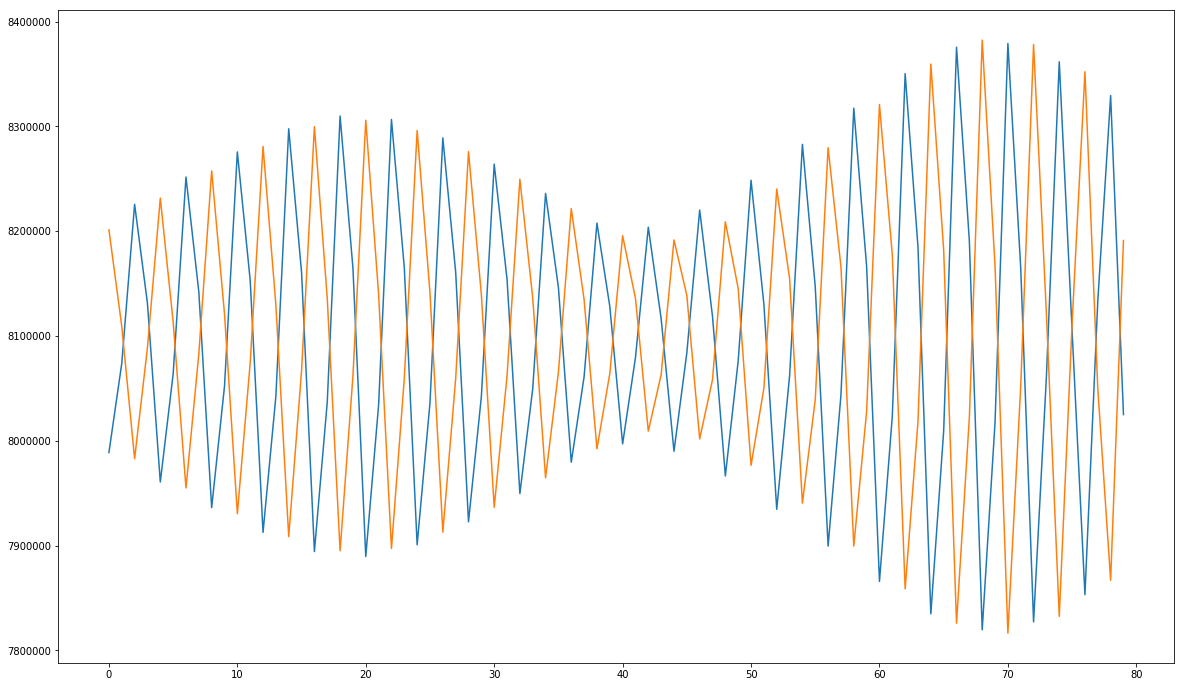

In [913]:
l = 17
x = lines[(910*l)+0:(910*l)+80]
plt.plot(x)
l = l + 1
x = lines[(910*l)+0:(910*l)+80]
plt.plot(x)


In [770]:
lineinfo_cur[100], lineinfo_cur[101]

(1160549.1033076106, 1163347.4488508701)

43.451705388955098

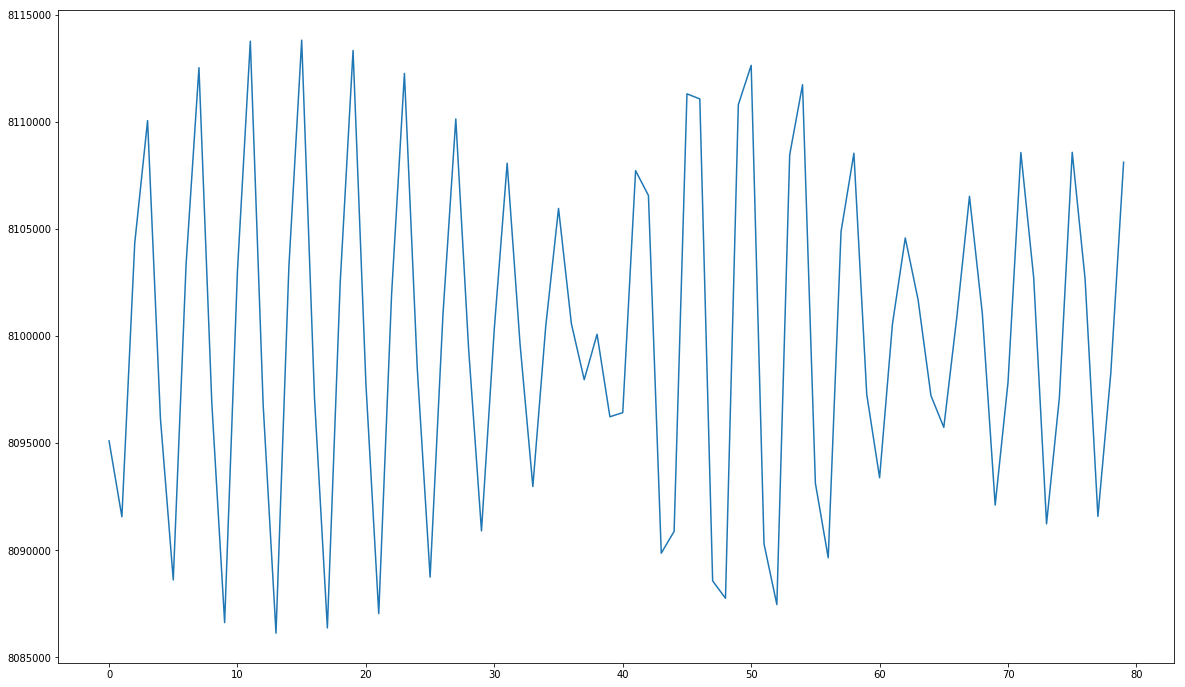

In [914]:
l = 17
x = lines[(910*l)+0:(910*l)+80]
#plt.plot(x)
l = l + 1
y = (x + lines[(910*l)+0:(910*l)+80]) / 2
plt.plot(y)
calcsnr(y[15:50])


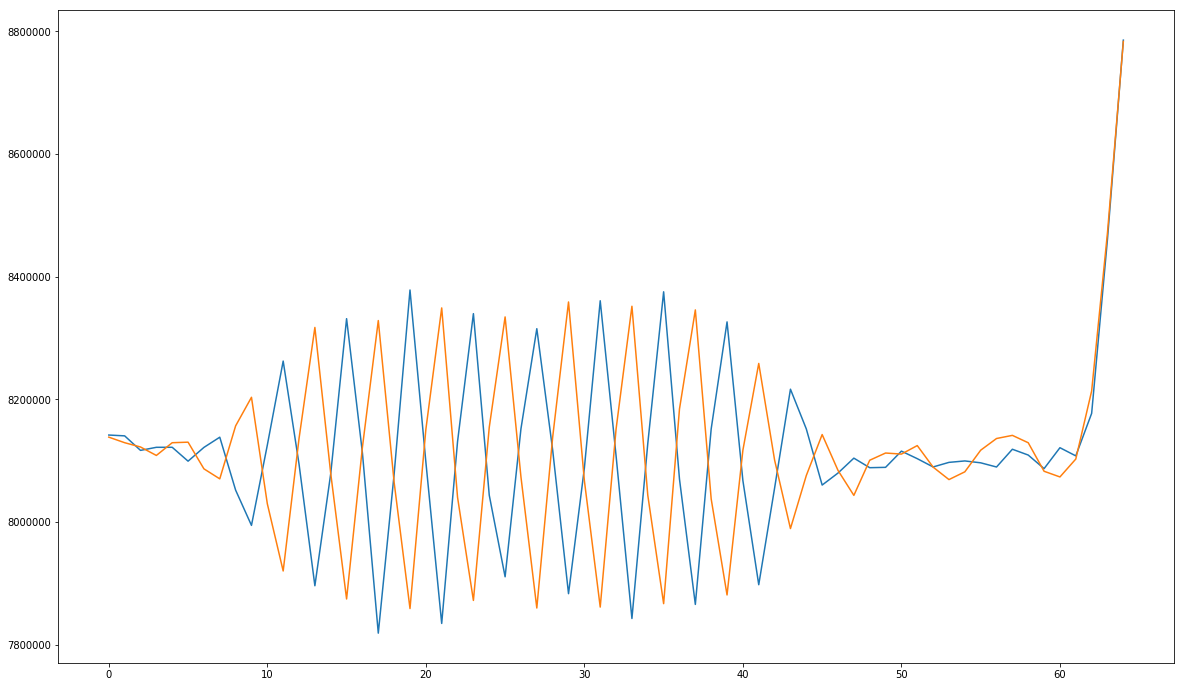

In [137]:
l = 50
x = lines[(910*l)+5:(910*l)+70]
plt.plot(x)
y = lines[(910*(l+1))+5:(910*(l+1))+70]
plt.plot(y)

22.0131165809


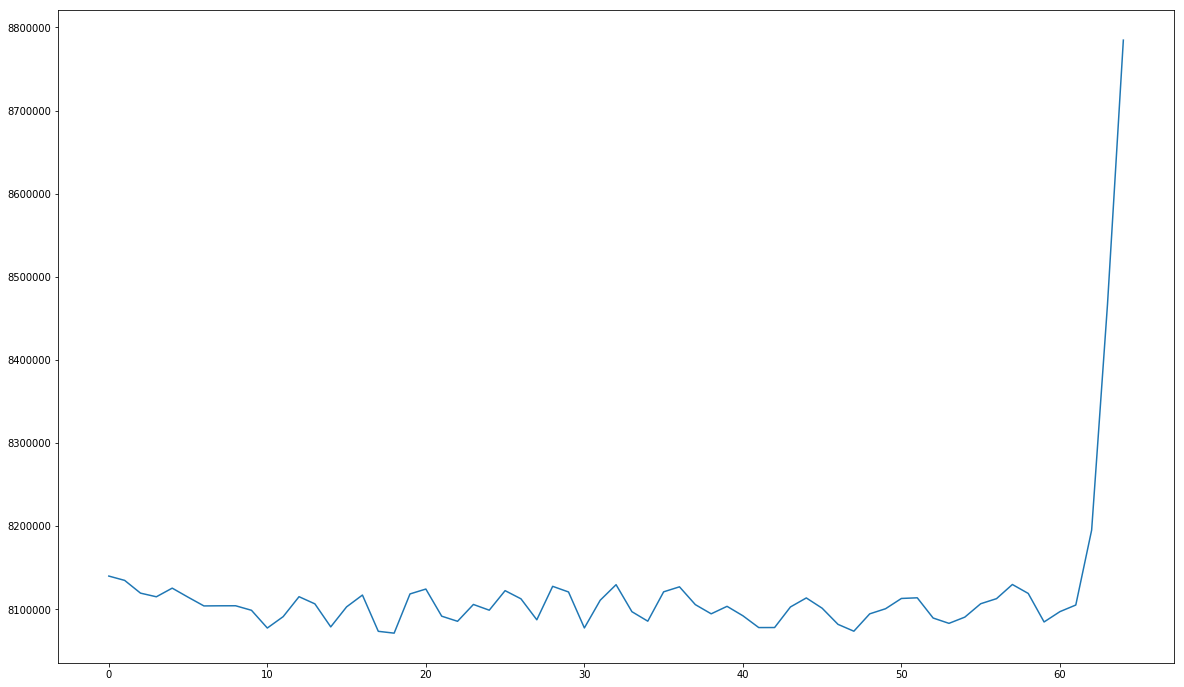

In [138]:
l = 50
x = lines[(910*l)+5:(910*l)+70] + lines[(910*(l+1))+5:(910*(l+1))+70]
plt.plot(x / 2)
calcsnr(x / 2)

(230230,)
uint8 (253, 910) (253, 910)


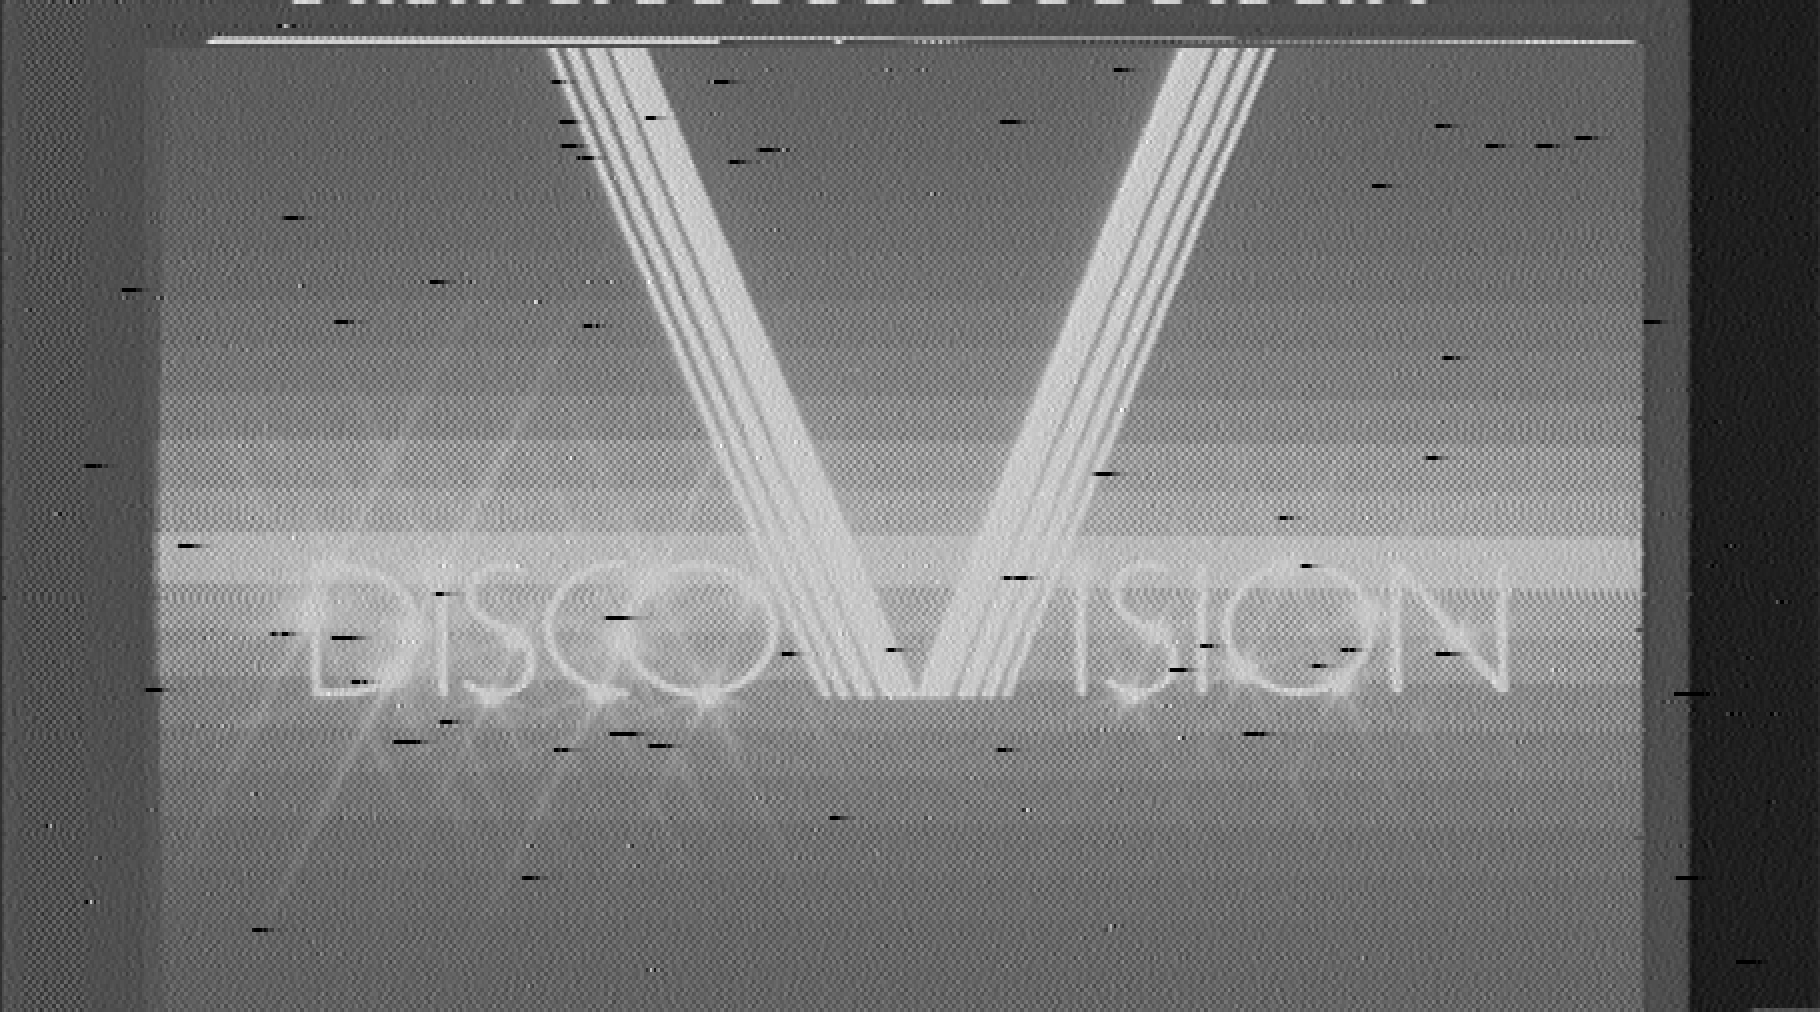

In [35]:
# Example of this code on a rotter :)
reduced = (lines - minn) / hz_ire_scale
lines16 = np.uint16(np.clip(reduced * out_scale, 0, 65535) + 0.5)

drawdata(lines16, 910, len(lineinfo2)-1, hscale=2, vscale=4)

In [36]:
# figure out where vsync is supposed to begin, assuming line start at ire -20:

In [37]:
910/63.5, 58.5*(910/63.5)

(14.330708661417322, 838.3464566929133)

In [38]:
begline = []
endline = []
for l in range(0, len(lineinfo_cur) - 1):
    cline = lines[l * 910:(l + 1) * 910]
    begline.append(calczc(cline, 0, 8000000, 5))
    endline.append(calczc(cline, 840, m20ire, 20))
    if (begline[-1] is None):
        print("b", l)
        begline[-1] = -1
    if (endline[-1] is None):
        print("e", l)
        endline[-1] = 844.25

e 173
e 219


In [39]:
np.min(begline), np.max(begline), np.mean(begline), np.argmax(begline), np.std(begline)

(0.36511998949632013,
 2.7357543924367347,
 0.76349998963594301,
 149,
 0.25001621551811237)

In [40]:
np.min(endline), np.max(endline), np.mean(endline), np.argmax(endline), np.std(endline)

(840.20959013105346,
 845.70162781330214,
 844.23547566598813,
 148,
 0.44573642405298891)

In [41]:
linegaps2 = np.diff(lineinfo2)
linegaps_end = np.diff(lineinfo_cur)

In [42]:
np.mean(linegaps2), np.std(linegaps2), np.min(linegaps2), np.max(linegaps2)

(2794.1198310133477,
 2.2242912880402335,
 2786.4846006617881,
 2799.5613464718917)

In [43]:
np.mean(linegaps_end), np.std(linegaps_end), np.min(linegaps_end), np.max(linegaps_end)

(2794.1198310133477,
 2.2716834575987628,
 2786.4032574766316,
 2800.2662368090241)

In [44]:
filterset['line_px']

2794.0

In [45]:
lineinfo2[147] - lineinfo2[146], lineinfo_cur[147] - lineinfo_cur[146]

(2792.3583034544718, 2792.7066011009738)

In [46]:
lineinfo2[120] - lineinfo2[119], lineinfo_cur[120] - lineinfo_cur[119]

(2791.6145233304705, 2792.2245435791556)

In [47]:
endline[147]

844.04832559894965

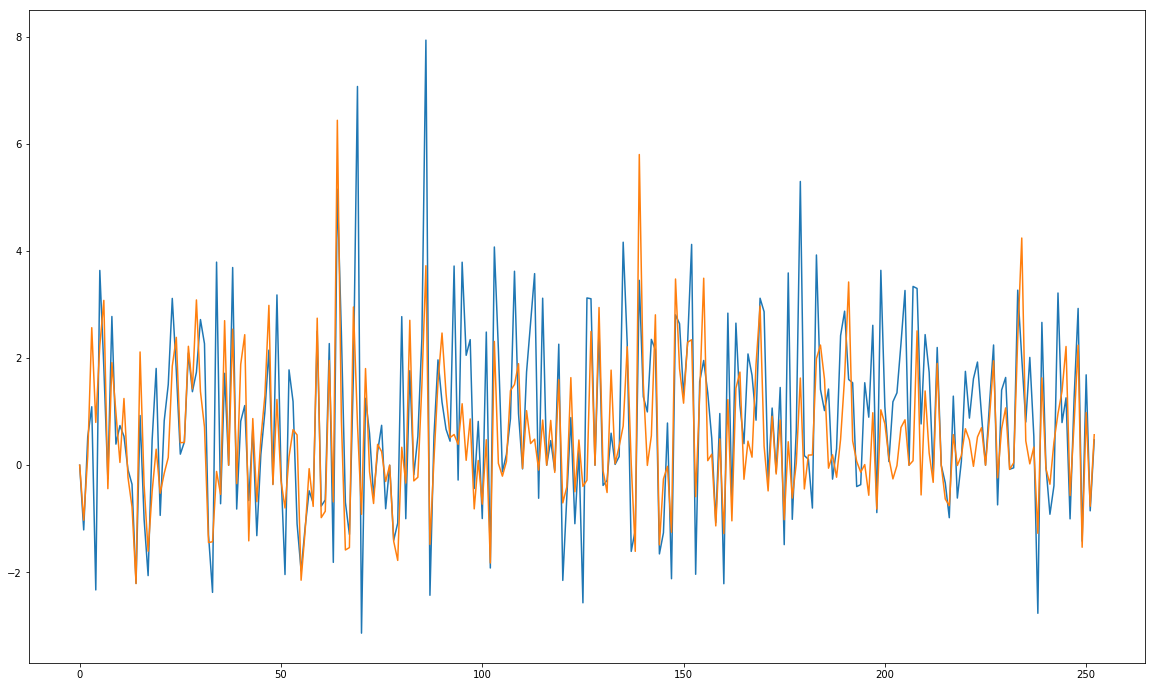

In [48]:
plt.plot(errs[0])
plt.plot(errs[-1])

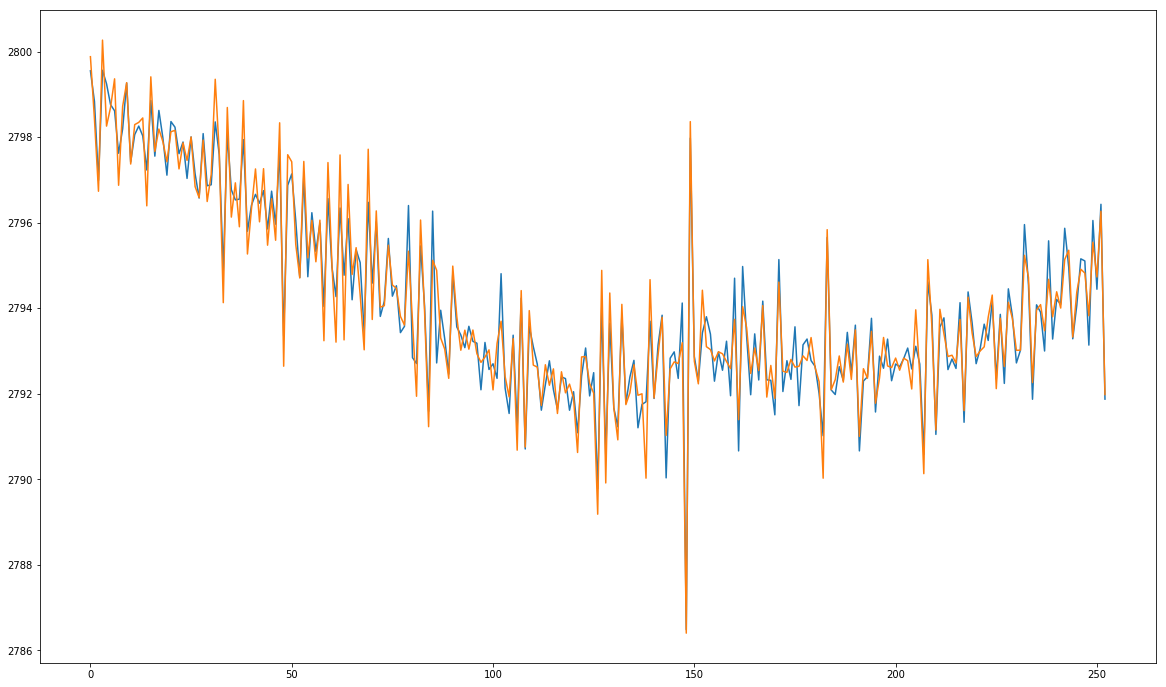

In [49]:
plt.plot(np.diff(lineinfo2))
plt.plot(np.diff(lineinfo_cur))